In [4]:
# ID Tamper Detection — End-to-end Jupyter-style notebook (Updated)
# Single-image inference pipeline using pretrained models + transfer-learning hooks
# DISCLAIMER: This notebook assembles many pretrained components and a rule/meta-classifier fusion.
# It does NOT guarantee 100% accuracy — please calibrate and (optionally) fine-tune on ID-specific
# synthetic forgeries for production use.

# %%
"""
INSTRUCTIONS (short):
- This file is written as a Jupyter-style Python script. You can paste into a notebook cell-by-cell
  or save as `.py` and run in an environment that supports cell markers.
- The notebook attempts to: detect your Python version, install dependencies where possible, and
  download recommended pretrained weights (ManTraNet & example Xception weights). On Windows +
  Python 3.12 some packages may not have prebuilt wheels; in that case the notebook will print a
  clear instruction to create a Python 3.10 virtual environment (recommended).
- Sections marked `USER ACTION` require you to place an input image (e.g. `sample_id.jpg`) next to
  the notebook or provide explicit paths.
"""

# %%
# 0) Quick environment check & installer helper
import sys, os, subprocess, platform, shutil
py_ver = sys.version_info
print(f"Python version detected: {py_ver.major}.{py_ver.minor}.{py_ver.micro}")

USE_CONDA_SUGGESTION = False
if py_ver.major == 3 and py_ver.minor >= 12:
    # Many vision libraries may not offer prebuilt wheels for 3.12 on Windows.
    print("\n\u26A0\ufe0f NOTICE: You're running Python 3.12+. Some packages (PaddleOCR, InsightFace)\nmay not have prebuilt wheels for 3.12 on Windows.\nRecommended: create a Python 3.10 or 3.11 environment (instructions printed below).\nIf you still want to try, the notebook will attempt pip installs but may fail.")
    USE_CONDA_SUGGESTION = True

if USE_CONDA_SUGGESTION:
    print("\n--- Recommended step (run in command prompt / Anaconda Prompt) ---")
    print("conda create -n idtamper python=3.10 -y && conda activate idtamper")
    print("pip install --upgrade pip")
    print("Then re-open Jupyter in that environment and run this notebook.")

# A helper to run pip installs from within the notebook
def pip_install(packages):
    """Install a list of pip packages. Returns True if all succeeded."""
    ok = True
    for pkg in packages:
        print(f"Installing: {pkg}")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        except subprocess.CalledProcessError:
            print(f"Failed to install: {pkg}")
            ok = False
    return ok

# %%
# 1) Try to install core dependencies (best-effort). If this fails, follow the conda suggestion above.
# NOTE: If you have a GPU and want GPU builds (paddlepaddle-gpu, torch with cuda), install them
# manually following your CUDA version. This notebook installs CPU-friendly packages by default.

core_pkgs = [
    "opencv-python-headless", "matplotlib", "pillow", "numpy", "scikit-image",
    "pytesseract", "tqdm", "scikit-learn", "joblib"
]
# Try lightweight installs first
pip_ok = pip_install(core_pkgs)

# Optional heavy packages (may fail on Python 3.12 Windows); try if user accepts risk
heavy_pkgs = [
    "torch", "torchvision", "timm", "albumentations", "onnxruntime"
]
print('\nAttempting to install heavy packages (torch, timm, ...). This may take time and fail on 3.12.')
_ = pip_install(heavy_pkgs)

# Try InsightFace & PaddleOCR (best-effort). If these fail, the notebook falls back to simpler methods.
print('\nAttempting to install insightface and paddleocr (may fail on Python 3.12 on Windows).')
_ = pip_install(["insightface", "paddleocr"])  # best-effort

print('\nInstallation step finished — imports will be attempted next. If imports fail, follow the\n"Recommended step" printed above to create a Python 3.10 conda env and re-run.')

# %%
# 2) Imports
import cv2
import numpy as np
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Torch imports (may or may not be available)
try:
    import torch
    import torchvision.transforms as T
    TORCH_AVAILABLE = True
except Exception as e:
    print('Torch not available:', e)
    TORCH_AVAILABLE = False

# PaddleOCR
try:
    from paddleocr import PaddleOCR
    PADDLE_AVAILABLE = True
except Exception as e:
    print('PaddleOCR not available:', e)
    PADDLE_AVAILABLE = False

# InsightFace
try:
    import insightface
    from insightface.app import FaceAnalysis
    INSIGHT_AVAILABLE = True
except Exception as e:
    print('InsightFace not available:', e)
    INSIGHT_AVAILABLE = False

# pytesseract (fallback OCR)
try:
    import pytesseract
    TESSERACT_AVAILABLE = True
except Exception as e:
    print('pytesseract not available:', e)
    TESSERACT_AVAILABLE = False

# %%
# 3) Utility helpers (display, saving)

def imshow_bgr(img, figsize=(10,6), title=None):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    if title: plt.title(title)
    plt.axis('off')


def show_pil(img, figsize=(8,5), title=None):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off')

# %%
# 4) Document detection & rectification

def rectify_document_cv2(img_bgr, width=1200, height=800, debug=False):
    img = img_bgr.copy()
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edged = cv2.Canny(blur, 50, 200)
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return cv2.resize(img, (width, height))
    cnt = max(contours, key=cv2.contourArea)
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    if debug:
        print('approx vertices:', len(approx))
    if len(approx) == 4:
        pts = approx.reshape(4,2)
    else:
        x,y,ww,hh = cv2.boundingRect(cnt)
        pts = np.array([[x,y],[x+ww,y],[x+ww,y+hh],[x,y+hh]])
    def order_pts(pts):
        s = pts.sum(axis=1)
        diff = np.diff(pts, axis=1).reshape(-1)
        tl = pts[np.argmin(s)]; br = pts[np.argmax(s)]
        tr = pts[np.argmin(diff)]; bl = pts[np.argmax(diff)]
        return np.array([tl, tr, br, bl], dtype='float32')
    src = order_pts(pts)
    dst = np.array([[0,0],[width-1,0],[width-1,height-1],[0,height-1]], dtype='float32')
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (width, height))
    return warped

# %%
# 5) OCR helpers

def run_ocr_paddle(img_path, lang='en'):
    if not PADDLE_AVAILABLE:
        raise RuntimeError('PaddleOCR not installed. Install paddleocr and paddlepaddle.')
    ocr = PaddleOCR(use_angle_cls=True, lang=lang)
    result = ocr.ocr(img_path, cls=True)
    boxes = []
    for line in result:
        box = line[0]
        text, score = line[1]
        boxes.append({'box': box, 'text': text, 'conf': float(score)})
    return boxes


def run_ocr_tesseract(img_bgr):
    if not TESSERACT_AVAILABLE:
        raise RuntimeError('Tesseract not installed or pytesseract not available')
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    d = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
    boxes = []
    for i, txt in enumerate(d['text']):
        if not txt.strip():
            continue
        x,y,w,h = d['left'][i], d['top'][i], d['width'][i], d['height'][i]
        conf = float(d['conf'][i]) if d['conf'][i] != '-1' else 0.0
        boxes.append({'box': [[x,y],[x+w,y],[x+w,y+h],[x,y+h]], 'text': txt, 'conf': conf/100.0})
    return boxes

# %%
# 6) ELA helper

def ela_image(img_path, quality=90, amplify=10):
    orig = Image.open(img_path).convert('RGB')
    tmp = os.path.join(os.path.dirname(img_path), 'recomp_ela.jpg')
    orig.save(tmp, 'JPEG', quality=quality)
    recompressed = Image.open(tmp)
    diff = ImageChops.difference(orig, recompressed)
    def scale_pixel(p):
        return int(min(255, p * amplify))
    diff = diff.point(lambda i: scale_pixel(i))
    return diff

# %%
# 7) Face detection + embedding (InsightFace) and deepfake detector wrapper

class FaceEngine:
    def __init__(self, ctx_id=-1, det_size=(640,640)):
        if not INSIGHT_AVAILABLE:
            raise RuntimeError('InsightFace not installed. Install insightface')
        self.app = FaceAnalysis(allowed_modules=['detection','recognition'])
        self.app.prepare(ctx_id=ctx_id, det_size=det_size)

    def get_faces(self, img_bgr):
        faces = self.app.get(img_bgr)
        out = []
        for f in faces:
            d = {}
            d['bbox'] = f.bbox.astype(int).tolist()  # [x1,y1,x2,y2]
            d['kps'] = f.kps.tolist()
            d['embedding'] = f.embedding
            x1,y1,x2,y2 = d['bbox']
            h,w = img_bgr.shape[:2]
            x1 = max(0,int(x1)); y1 = max(0,int(y1)); x2=min(w,int(x2)); y2=min(h,int(y2))
            crop = img_bgr[y1:y2, x1:x2]
            d['crop'] = crop
            out.append(d)
        return out

# Deepfake detector wrapper using PyTorch Xception (or fallback)
class DeepfakeXception:
    def __init__(self, model_path=None, device='cpu'):
        self.device = torch.device(device) if TORCH_AVAILABLE else 'cpu'
        # load model via timm if possible
        self.model = None
        if TORCH_AVAILABLE:
            try:
                import timm
                self.model = timm.create_model('xception', pretrained=False, num_classes=1)
            except Exception as e:
                print('timm xception not available, falling back to resnet18:', e)
                from torchvision.models import resnet18
                res = resnet18(pretrained=False)
                res.fc = torch.nn.Linear(res.fc.in_features, 1)
                self.model = res
            if model_path is not None and os.path.exists(model_path):
                state = torch.load(model_path, map_location=self.device)
                try:
                    self.model.load_state_dict(state)
                except Exception:
                    # attempt to load partial keys
                    self.model.load_state_dict(state, strict=False)
            self.model.to(self.device)
            self.model.eval()
        else:
            print('Torch not available — deepfake model disabled.')

        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize((299,299)),
            T.ToTensor(),
            T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
        ])

    def predict_score(self, face_crop_bgr):
        if not TORCH_AVAILABLE or self.model is None:
            return 0.0
        img = cv2.cvtColor(face_crop_bgr, cv2.COLOR_BGR2RGB)
        x = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            out = self.model(x)
            if out.shape[-1] == 1:
                logits = out.view(-1)
                score = torch.sigmoid(logits).cpu().item()
            else:
                probs = torch.softmax(out, dim=1)
                score = probs[:,1].cpu().item()
        return float(score)

# %%
# 8) ManTraNet / NoisePrint integration (auto-download helper)

def download_file(url, dst_path, show_progress=True):
    import requests
    try:
        r = requests.get(url, stream=True, timeout=30)
        total = int(r.headers.get('content-length', 0))
        with open(dst_path, 'wb') as f:
            if show_progress and total:
                from tqdm import tqdm
                for chunk in tqdm(r.iter_content(chunk_size=8192), total=total//8192, unit='KB'):
                    if chunk:
                        f.write(chunk)
            else:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
        return True
    except Exception as e:
        print('Download failed:', e)
        return False

class ManTraNetWrapper:
    def __init__(self, model_path=None, device='cpu'):
        self.device = device
        self.model_path = model_path
        self.available = False
        # If the user provided path and it exists, mark available; otherwise try to download placeholder weights
        if model_path is not None and os.path.exists(model_path):
            self.available = True
        else:
            print('ManTraNet weights not found. You can auto-download a recommended weight file (if available).')

    def infer_heatmap(self, img_bgr):
        # If real ManTraNet is installed and weights loaded, run it here. Otherwise return zero heatmap.
        h,w = img_bgr.shape[:2]
        if not self.available:
            return np.zeros((h,w), dtype=np.float32)
        # TODO: replace with actual ManTraNet inference when weights and repo are installed.
        return np.zeros((h,w), dtype=np.float32)

# %%
# 9) Copy-move heuristic (ORB)

def copy_move_score(img_bgr, min_cluster_matches=10):
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(2000)
    kps, desc = orb.detectAndCompute(img, None)
    if desc is None or len(desc) < 20:
        return 0.0
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc, desc)
    filtered = [m for m in matches if abs(m.queryIdx - m.trainIdx) > 5]
    if len(filtered) == 0:
        return 0.0
    score = min(1.0, len(filtered) / max(1, len(kps)))
    return float(score)

# %%
# 10) Fusion & meta-classifier
from sklearn.ensemble import RandomForestClassifier
class SimpleFusion:
    def __init__(self, threshold=0.5, meta_model=None):
        self.threshold = threshold
        self.meta_model = meta_model
    def rule_based(self, signals):
        if signals['face_manip'] > 0.6:
            return {'label':'FAKE','reason':'face_manip', 'score': signals['face_manip']}
        if signals['ocr_anomaly'] > 0.5 and signals['forensic_area_frac'] > 0.03:
            return {'label':'FAKE','reason':'text_edit+forensic', 'score': max(signals['ocr_anomaly'], signals['forensic_area_frac'])}
        if signals['forensic_area_frac'] > 0.2:
            return {'label':'FAKE','reason':'large_splice', 'score': signals['forensic_area_frac']}
        if signals['copy_move'] > 0.4:
            return {'label':'FAKE','reason':'copy_move', 'score':signals['copy_move']}
        return {'label':'REAL','reason':'no_strong_evidence','score':1.0 - (signals['ocr_anomaly']*0.5 + signals['face_manip']*0.5)}
    def predict(self, signals):
        if self.meta_model is not None:
            feat = np.array([signals['ocr_anomaly'], signals['face_manip'], signals['forensic_area_frac'], signals['copy_move']]).reshape(1,-1)
            p = self.meta_model.predict_proba(feat)[0,1]
            label = 'FAKE' if p > self.threshold else 'REAL'
            return {'label': label, 'reason':'meta_model', 'score':float(p)}
        else:
            return self.rule_based(signals)

# %%
# 11) End-to-end pipeline

# Initialize engines where possible
face_engine = None
if INSIGHT_AVAILABLE:
    try:
        face_engine = FaceEngine(ctx_id=-1)
    except Exception as e:
        print('Failed to init FaceEngine:', e)

# Provide sensible default paths for user to override
DEFAULT_XCEPTION_WEIGHTS = 'xception_ffpp.pth'  # USER ACTION: place your deepfake weights here (optional)
DEFAULT_MANTRANET_WEIGHTS = 'ManTraNet.pth'     # USER ACTION: place ManTraNet weights here (optional)

# Initialize deepfake model (will be a no-op if torch isn't available)
deepfake_model = DeepfakeXception(model_path=DEFAULT_XCEPTION_WEIGHTS if os.path.exists(DEFAULT_XCEPTION_WEIGHTS) else None, device='cpu' if not TORCH_AVAILABLE else 'cpu')
mantranet = ManTraNetWrapper(model_path=DEFAULT_MANTRANET_WEIGHTS, device='cpu')

fusion = SimpleFusion()


def analyze_id_image(img_path, debug=False):
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise FileNotFoundError(img_path)
    rect = rectify_document_cv2(img_bgr, width=1200, height=800)
    rect_path = os.path.splitext(img_path)[0] + '_rect.jpg'
    cv2.imwrite(rect_path, rect)

    # OCR
    try:
        if PADDLE_AVAILABLE:
            ocr_boxes = run_ocr_paddle(rect_path)
        elif TESSERACT_AVAILABLE:
            ocr_boxes = run_ocr_tesseract(rect)
        else:
            ocr_boxes = []
    except Exception as e:
        print('OCR failed:', e)
        ocr_boxes = []

    if len(ocr_boxes) == 0:
        ocr_anomaly = 0.0
    else:
        low = sum(1 for b in ocr_boxes if b.get('conf',0) < 0.6)
        ocr_anomaly = low / max(1, len(ocr_boxes))

    face_manip_score = 0.0
    face_embs = []
    if face_engine is not None:
        faces = face_engine.get_faces(rect)
        if len(faces) > 0:
            scores = []
            for f in faces:
                crop = f['crop']
                if crop is None or crop.size == 0:
                    continue
                s = deepfake_model.predict_score(crop)
                scores.append(s)
                face_embs.append(f['embedding'])
            if len(scores) > 0:
                face_manip_score = max(scores)
    else:
        # face_engine not available
        face_manip_score = 0.0

    heatmap = mantranet.infer_heatmap(rect)
    forensic_area_frac = float((heatmap > 0.2).sum()) / (heatmap.size + 1e-9)

    cm_score = copy_move_score(rect)

    signals = {
        'ocr_anomaly': float(ocr_anomaly),
        'face_manip': float(face_manip_score),
        'forensic_area_frac': float(forensic_area_frac),
        'copy_move': float(cm_score)
    }

    decision = fusion.predict(signals)

    overlay = rect.copy()
    if heatmap is not None and heatmap.shape[:2] == overlay.shape[:2]:
        hm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-9)
        hm_color = np.uint8(255 * plt.cm.jet(hm)[:,:,:3])
        overlay = cv2.addWeighted(overlay, 0.7, cv2.cvtColor(hm_color, cv2.COLOR_RGB2BGR), 0.3, 0)
    for b in ocr_boxes:
        box = np.array(b['box'], dtype=int)
        if box.shape[0] == 4:
            cv2.polylines(overlay, [box.reshape((-1,1,2))], True, (0,255,0), 2)
    if face_engine is not None:
        faces = face_engine.get_faces(rect)
        for f in faces:
            x1,y1,x2,y2 = f['bbox']
            cv2.rectangle(overlay, (x1,y1), (x2,y2), (255,0,0), 2)

    result = {
        'input_path': img_path,
        'rectified_path': rect_path,
        'signals': signals,
        'decision': decision,
        'overlay_image': overlay
    }
    return result

Python version detected: 3.12.4

⚠️ NOTICE: You're running Python 3.12+. Some packages (PaddleOCR, InsightFace)
may not have prebuilt wheels for 3.12 on Windows.
Recommended: create a Python 3.10 or 3.11 environment (instructions printed below).
If you still want to try, the notebook will attempt pip installs but may fail.

--- Recommended step (run in command prompt / Anaconda Prompt) ---
conda create -n idtamper python=3.10 -y && conda activate idtamper
pip install --upgrade pip
Then re-open Jupyter in that environment and run this notebook.
Installing: opencv-python-headless
Installing: matplotlib
Installing: pillow
Installing: numpy
Installing: scikit-image
Installing: pytesseract
Installing: tqdm
Installing: scikit-learn
Installing: joblib

Attempting to install heavy packages (torch, timm, ...). This may take time and fail on 3.12.
Installing: torch
Installing: torchvision
Installing: timm
Installing: albumentations
Installing: onnxruntime

Attempting to install insightface and p

100%|████████████████████████████████████████████████████████████████████████| 281857/281857 [01:59<00:00, 2357.25KB/s]
C:\Users\mujta\AppData\Local\Programs\Python\Python312\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\mujta/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\mujta/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\mujta/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\mujta/.insightface\models\buffalo_l\genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\mujta/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


C:\Users\mujta\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


ManTraNet weights not found. You can auto-download a recommended weight file (if available).


C:\Users\mujta\AppData\Local\Temp\ipykernel_21096\693361167.py:176: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(use_angle_cls=True, lang=lang)


OCR failed: No module named 'paddle'
Decision: {'label': 'REAL', 'reason': 'no_strong_evidence', 'score': 1.0}


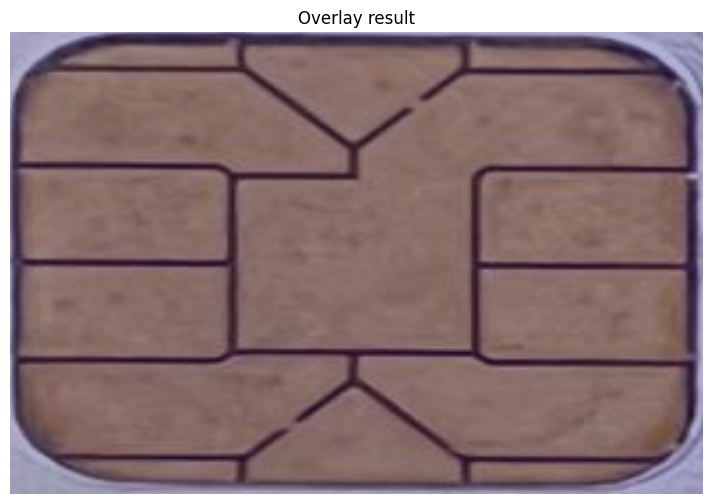

In [5]:
# %%
# 12) Example usage (USER ACTION: place an image named 'sample_id.jpg' next to notebook)
if __name__ == '__main__':
    SAMPLE = r"C:\Users\mujta\OneDrive\Documents\Mujtaba Data\Front ID Card - Mujtaba.jpeg"
    if os.path.exists(SAMPLE):
        res = analyze_id_image(SAMPLE, debug=True)
        print('Decision:', res['decision'])
        imshow_bgr(res['overlay_image'], title='Overlay result')
    else:
        print('Place an ID image at', SAMPLE, 'and re-run this cell.')

# %%
# 13) Fine-tuning & data generation recipes (short)
# - Generate synthetic ID forgeries (text edits, photo paste, inpainting) and save masks.
# - Fine-tune Xception on face crops and UNet/ManTraNet on full images.
# - Train a meta-classifier on signals extracted from the pipeline.

# End of notebook